Before you turn this coursework in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

In [43]:
NAME = "Yuliang Zhou"
CIS_USERNAME = "dhjb18"

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [27]:
# YOUR CODE HERE
#raise NotImplementedError()
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
import re
from nltk.corpus import stopwords
from string import punctuation

#load data
df_raw = pd.read_csv('food_reviews.csv', header=0) 
#check data 
# df_raw.shape[0]
# df_raw['Score'].value_counts(normalize=True)
# df_raw['Text'].str.len().max()

df_raw.drop(df_raw[df_raw.Text.str.len() < 50].index, inplace=True)
df_raw = df_raw.reset_index(drop=True)

#connect Summary and Text together, because I think they are all useful
df_raw['overallreview'] = df_raw['Summary'].astype(str)+ ' ' + df_raw['Text'].astype(str)

def get_words_preprocessed(text):
    #punctuation_list = list(punctuation)
    stopwords_english = stopwords.words('english') 
    text = re.sub(r'<.*?>', '', text)# Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # I tried to use punctuation, but find re performs better at removing the punctuations and symbols
    
    words = text.split()
    result = []
    
    for word in words:
        if word.lower() not in stopwords_english: #remove stop words
            result.append(word.lower()) #lowercase 
    return result

def copus_process(dataframe):
    dataframe['overallreview'] = dataframe['overallreview'].apply(get_words_preprocessed)
    count_row = dataframe.shape[0] 
    dataset = []
    for i in range(count_row):
        text = " ".join(dataframe['overallreview'][i]) 
        dataset.append(text)
   
    X = dataset 
    y = dataframe['Score']  
    return X,y

#because the class unbalance in target variable 'Score'
#I use two ways for training data set: 1) random sampling 2)stratified sampling 
#for test data set, I use random sampling method, and use the same test data set through this report
def sampling(dataframe):
    # Splitting the original dataset into train and test datasets
    sample_size_test = 3000
    df_train, df_test = train_test_split(df_raw, test_size=sample_size_test, random_state=42)

    # Training dataset selection using random sampling
    sample_size_train_rd = 7000
    df_train_rd = df_train.sample(n=sample_size_train_rd, random_state=42)
    df_train_rd.reset_index(drop=True, inplace=True)
    samples_train_rd, labels_train_rd = copus_process(df_train_rd)

    # Training dataset selection using stratified sampling
    sample_size_train_str = 7000
    stratum_proportions = df_train['Score'].value_counts(normalize=True)
    sampling_fracs = sample_size_train_str / df_train.groupby('Score').size()
    df_train_str = df_train.groupby('Score', group_keys=False).apply(lambda x: x.sample(frac=sampling_fracs[x.name], random_state=42))
    df_train_str.reset_index(drop=True, inplace=True)
    samples_train_str, labels_train_str = copus_process(df_train_str)

    # Preprocessing the test dataset
    df_test.reset_index(drop=True, inplace=True)
    samples_test, labels_test= copus_process(df_test)
    
    print("Training samples random method:" , len(samples_train_rd))
    print("Training samples stratified method:" , len(samples_train_rd))
    print("Test samples" , len(samples_test))
    return samples_train_rd, labels_train_rd, samples_train_str, labels_train_str, samples_test, labels_test

samples_train_rd, labels_train_rd, samples_train_str, labels_train_str, samples_test, labels_test= sampling(df_raw)

## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

In [29]:
# YOUR CODE HERE
#raise NotImplementedError()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def model_nb(samples_train, samples_test, labels_train, labels_test):
    model_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model_nb.fit(samples_train, labels_train) 
    predicted_categories_nb = model_nb.predict(samples_test) 

    print("Predicted:",predicted_categories_nb.tolist()[0:10])
    return model_nb,predicted_categories_nb

print("Ground truth:",labels_test.tolist()[0:10])
print("\n")
print("random sampling predicted")
model_nb_rd,predicted_categories_nb_rd = model_nb(samples_train_rd, samples_test, labels_train_rd, labels_test)
print("\n")
print("stratified sampling predicted")
model_nb_str,predicted_categories_nb_str = model_nb(samples_train_str, samples_test, labels_train_str, labels_test)


Ground truth: [5, 3, 5, 1, 5, 5, 5, 5, 5, 5]


random sampling predicted
Predicted: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


stratified sampling predicted
Predicted: [4, 3, 5, 1, 4, 4, 5, 5, 4, 5]


## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

Current k value: 1
k = 1 Accuracy -> 0.528 f1 score -> 0.276741953840848
Current k value: 3
k = 3 Accuracy -> 0.5607142857142857 f1 score -> 0.26926976508035094
Current k value: 5
k = 5 Accuracy -> 0.6037142857142856 f1 score -> 0.27720165268511
Current k value: 7
k = 7 Accuracy -> 0.6241428571428571 f1 score -> 0.2641513759299015


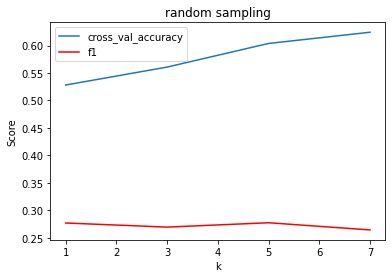

In [30]:
# YOUR CODE HERE
#raise NotImplementedError()
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

k_list = np.array([1,3,5,7])

def knn_cross(samples_train, samples_test, labels_train, labels_test):
    cross_val_accuracy = []
    cross_val_f1 = []
    for i in range(len(k_list)):    
        k = k_list[i]
        print("Current k value:", k)
        # build model using tf-idf method
        model_knn = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k_list[i]))
        model_knn.fit(samples_train, labels_train)
        #use cross-validation accuracy and f1 to evaluate the model
        accuracy = cross_val_score(model_knn, samples_train, labels_train, cv=4, scoring='accuracy')
        cross_val_accuracy.append(np.mean(accuracy))

        f1 = cross_val_score(model_knn, samples_train, labels_train, cv=4, scoring='f1_macro')
        cross_val_f1.append(np.mean(f1))
        print("k =", k_list[i], "Accuracy ->", np.mean(accuracy), "f1 score ->", np.mean(f1))
    return cross_val_accuracy,cross_val_f1

cross_val_accuracy_rd,cross_val_f1_rd = knn_cross(samples_train_rd, samples_test, labels_train_rd, labels_test)

plt.plot(k_list, cross_val_accuracy_rd, label='cross_val_accuracy')
plt.plot(k_list, cross_val_f1_rd, label='f1', color = 'red')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.title('random sampling')
plt.show()


def final_knn_model(samples_train, samples_test, labels_train, labels_test,k):
    model_knn = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
    model_knn.fit(samples_train, labels_train)
    predicted_categories_knn = model_knn.predict(samples_test)
    print("Predicted:",predicted_categories_knn.tolist()[0:20]) 
    print("Ground truth:",labels_test.tolist()[0:20]) 
    return model_knn,predicted_categories_knn

# for random sampling, decide to use k = 5 
print('random sampling predicted')
model_knn_rd,predicted_categories_knn_rd = final_knn_model(samples_train_rd, samples_test, labels_train_rd, labels_test,5)


# cross_val_accuracy_str,cross_val_f1_str = knn_cross(samples_train_str, samples_test, labels_train_str, labels_test)

# plt.plot(k_list, cross_val_accuracy_str, label='cross_val_accuracy')
# plt.plot(k_list, cross_val_f1_str, label='f1', color = 'red')
# plt.xlabel('k')
# plt.ylabel('Score')
# plt.legend()
# plt.title('stratified sampling ')
# plt.show()

#for stratified sampling, decide to use k = 
# print("\n")
# print("stratified sampling predicted")
# model_knn_str,predicted_categories_knn_str = final_knn_model(samples_train_str, samples_test, labels_train_str, labels_test,5)


## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

random sampling predicted
Epoch 1/5
197/197 [==============================] - 23s 112ms/step - loss: 1.0646 - accuracy: 0.6362 - val_loss: 0.9000 - val_accuracy: 0.6857
Epoch 2/5
197/197 [==============================] - 23s 116ms/step - loss: 0.7238 - accuracy: 0.7278 - val_loss: 0.8504 - val_accuracy: 0.7057
Epoch 3/5
197/197 [==============================] - 25s 125ms/step - loss: 0.3450 - accuracy: 0.8775 - val_loss: 1.0887 - val_accuracy: 0.6657
Epoch 4/5
197/197 [==============================] - 22s 112ms/step - loss: 0.0894 - accuracy: 0.9846 - val_loss: 1.2651 - val_accuracy: 0.6929
Epoch 5/5
94/94 [==============================] - 2s 24ms/step - loss: 1.2677 - accuracy: 0.6977
Test Loss: 1.267702341079712
Test Accuracy: 0.6976666450500488


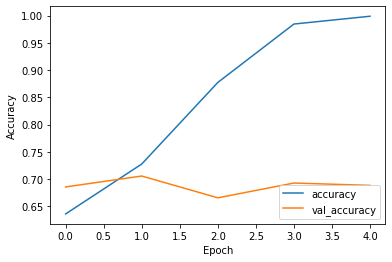

94/94 [==============================] - 2s 24ms/step


stratified sampling predicted
Epoch 1/5
985/985 [==============================] - 419s 425ms/step - loss: 1.2030 - accuracy: 0.4722 - val_loss: 1.0526 - val_accuracy: 0.5854
Epoch 2/5
985/985 [==============================] - 422s 429ms/step - loss: 0.7285 - accuracy: 0.7168 - val_loss: 1.2866 - val_accuracy: 0.4486
Epoch 3/5
985/985 [==============================] - 457s 464ms/step - loss: 0.2406 - accuracy: 0.9243 - val_loss: 1.3746 - val_accuracy: 0.5377
Epoch 4/5
985/985 [==============================] - 462s 469ms/step - loss: 0.0457 - accuracy: 0.9908 - val_loss: 1.7650 - val_accuracy: 0.5243
Epoch 5/5
94/94 [==============================] - 8s 88ms/step - loss: 2.2961 - accuracy: 0.5197
Test Loss: 2.2961254119873047
Test Accuracy: 0.5196666717529297


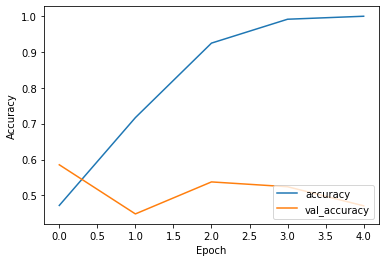

94/94 [==============================] - 8s 87ms/step


In [32]:
# YOUR CODE HERE
#raise NotImplementedError()
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def cnn_model(samples_train, samples_test, labels_train, labels_test):
    # Tokenize and pad sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples_train)

    X_train = tokenizer.texts_to_sequences(samples_train)
    X_test = tokenizer.texts_to_sequences(samples_test)

    max_sequence_length = max(len(seq) for seq in X_train + X_test)
    X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length)
    X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length)

    Y_train = np.array(labels_train) - 1
    Y_test = np.array(labels_test) - 1

    # Build the CNN model
    model_cnn = Sequential()
    model_cnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)) #, input_length=max_sequence_length
    model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(5, activation='softmax'))

    model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_cnn.fit(X_train_padded, Y_train, epochs=5, validation_split=0.1)

    # Evaluate the model
    loss, accuracy = model_cnn.evaluate(X_test_padded, Y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Predict probabilities for each class
    Y_pred_probabilities = model_cnn.predict(X_test_padded)

    # Extract predicted classes (argmax of predicted probabilities)
    predicted_categories_cnn = np.argmax(Y_pred_probabilities, axis=1)
    return model_cnn,predicted_categories_cnn

print('random sampling predicted')
model_cnn_rd,predicted_categories_cnn_rd = cnn_model(samples_train_rd, samples_test, labels_train_rd, labels_test)
print("\n")
print("stratified sampling predicted")
model_cnn_str,predicted_categories_cnn_str = cnn_model(samples_train_str, samples_test, labels_train_str, labels_test)


## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def rnn_model(samples_train, samples_test, labels_train, labels_test):
    # Tokenize text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples_train)
    sequences_train = tokenizer.texts_to_sequences(samples_train)
    sequences_test = tokenizer.texts_to_sequences(samples_test)

    # Pad sequences
    max_sequence_length = 100  # choose appropriate sequence length
    X_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
    X_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

    # Convert labels to categorical format
    num_classes = len(np.unique(labels_train))
    y_train = to_categorical(labels_train - 1, num_classes=num_classes)
    y_test = to_categorical(labels_test - 1, num_classes=num_classes)

    # Define RNN model
    model_rnn = Sequential()
    model_rnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
    model_rnn.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model_rnn.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model_rnn.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

    # Evaluate the model
    loss, accuracy = model_rnn.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    # Predict probabilities for each class
    Y_pred_probabilities_rnn = model_rnn.predict(X_test)

    # Extract predicted classes (argmax of predicted probabilities)
    predicted_categories_rnn = np.argmax(Y_pred_probabilities_rnn, axis=1)
    return model_rnn,predicted_categories_rnn


print('random sampling predicted')
model_rnn_rd,predicted_categories_rnn_rd = rnn_model(samples_train_rd, samples_test, labels_train_rd, labels_test)
print("\n")
print("stratified sampling predicted")
model_rnn_str,predicted_categories_rnn_str = rnn_model(samples_train_str, samples_test, labels_train_str, labels_test)


random sampling predicted
Epoch 1/5
110/110 [==============================] - 34s 289ms/step - loss: 1.0996 - accuracy: 0.6310 - val_loss: 0.8978 - val_accuracy: 0.6620
Epoch 2/5
110/110 [==============================] - 31s 286ms/step - loss: 0.7899 - accuracy: 0.6994 - val_loss: 0.9111 - val_accuracy: 0.6840
Epoch 3/5
110/110 [==============================] - 32s 288ms/step - loss: 0.6161 - accuracy: 0.7580 - val_loss: 0.9255 - val_accuracy: 0.6650
Epoch 4/5
110/110 [==============================] - 31s 286ms/step - loss: 0.4588 - accuracy: 0.8300 - val_loss: 0.9970 - val_accuracy: 0.6860
Epoch 5/5
94/94 [==============================] - 2s 26ms/step - loss: 1.0807 - accuracy: 0.6703
Test Loss: 1.0807271003723145
Test Accuracy: 0.6703333258628845
94/94 [==============================] - 3s 26ms/step


stratified sampling predicted
Epoch 1/5
547/547 [==============================] - 181s 327ms/step - loss: 1.2548 - accuracy: 0.4541 - val_loss: 0.9498 - val_accuracy: 0.6483
Epoch

## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

Naive Bayes
NB_random sampling predicted


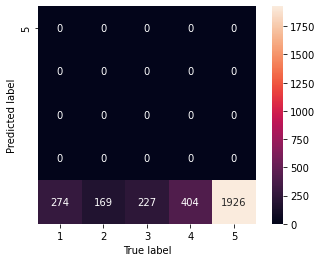

/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:	0.642000
F1-score:	0.156395
Precision:	0.128400
Recall:		0.200000


NB_stratified sampling predicted


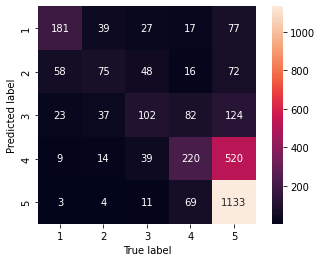

Accuracy:	0.570333
F1-score:	0.471813
Precision:	0.457956
Recall:		0.537306


KNN
KNN_random sampling predicted


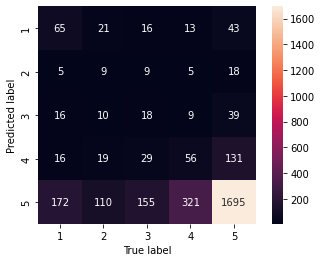

Accuracy:	0.614333
F1-score:	0.288528
Precision:	0.343359
Recall:		0.277690


CNN
CNN_random sampling predicted


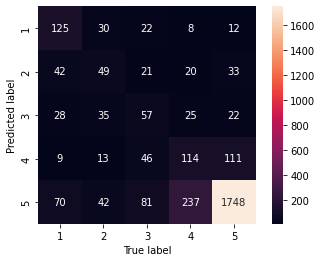

Accuracy:	0.697667
F1-score:	0.458501
Precision:	0.492891
Recall:		0.437401


CNN_stratified sampling predicted


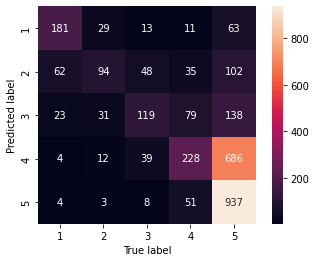

Accuracy:	0.519667
F1-score:	0.472054
Precision:	0.471941
Recall:		0.558377


RNN
RNN_random sampling predicted


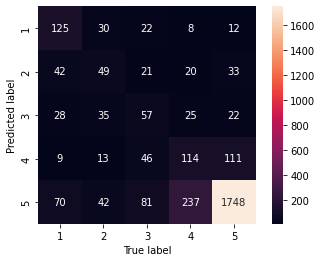

Accuracy:	0.697667
F1-score:	0.458501
Precision:	0.492891
Recall:		0.437401


RNN_stratified sampling predicted


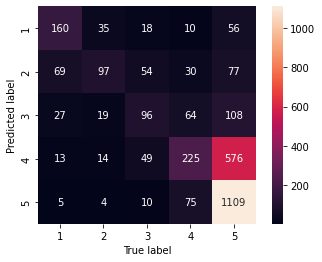

Accuracy:	0.562333
F1-score:	0.476966
Precision:	0.470853
Recall:		0.542710




In [41]:
# YOUR CODE HERE
#raise NotImplementedError()

def model_performance(model_type,labels_test, predicted_categories):
    mat = confusion_matrix(labels_test, predicted_categories)
    sns.heatmap(mat.T, square = True, annot=True, fmt = "d",xticklabels=np.unique(labels_test),yticklabels=np.unique(predicted_categories))

    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()
    
    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(labels_test, predicted_categories)
    precision = precision_score(labels_test, predicted_categories, average='macro')
    recall = recall_score(labels_test, predicted_categories, average='macro')
    f1 = f1_score(labels_test, predicted_categories, average='macro')

    # Print performance metrics
    print("Accuracy:\t%f" % accuracy)
    print("F1-score:\t%f" % f1)
    print("Precision:\t%f" % precision)
    print("Recall:\t\t%f" % recall)
    print("\n")

print("Naive Bayes")
print('NB_random sampling predicted')
model_performance('NB',labels_test, predicted_categories_nb_rd)
print("NB_stratified sampling predicted")
model_performance('NB',labels_test, predicted_categories_nb_str)

print("KNN")
print('KNN_random sampling predicted')
model_performance('KNN',labels_test, predicted_categories_knn_rd)
# print("KNN_stratified sampling predicted")
# predicted_categories = predicted_categories_knn_str+1
# model_performance('KNN',labels_test, predicted_categories)


print("CNN")
print('CNN_random sampling predicted')
predicted_categories = predicted_categories_cnn_rd+1
model_performance('CNN',labels_test, predicted_categories)
print("CNN_stratified sampling predicted")
predicted_categories = predicted_categories_cnn_str+1
model_performance('CNN',labels_test, predicted_categories)


print("RNN")
print('RNN_random sampling predicted')
predicted_categories = predicted_categories_cnn_rd+1
model_performance('RNN',labels_test, predicted_categories)
print("RNN_stratified sampling predicted")
predicted_categories = predicted_categories_rnn_str+1
model_performance('RNN',labels_test, predicted_categories)

## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

In [39]:
# YOUR CODE HERE
#raise NotImplementedError()
import pickle

pickle.dump(model_nb_str, open('model_nb.pkl', 'wb'))

pickle.dump(model_knn_rd, open('model_knn.pkl', 'wb'))

pickle.dump(model_cnn_str, open('model_cnn.pkl', 'wb'))

pickle.dump(model_rnn_str, open('model_rnn.pkl', 'wb'))

def predict_food_review(text,model):
    if model == 'Naive Bayes':
        loaded_model = pickle.load(open('model_nb.pkl', 'rb')) #for nb, choose stratified sampling method
        predicted_categories = loaded_model.predict([text])[0]
        print('Naive Bayes predicted Score: ', predicted_categories)
        
    elif model == 'KNN':
        loaded_model = pickle.load(open('model_knn.pkl', 'rb'))
        predicted_categories = loaded_model.predict([text])[0]
        print('KNN predicted Score: ', predicted_categories)
    elif model == 'CNN':
        loaded_model = pickle.load(open('model_cnn.pkl', 'rb'))
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts([text])
        sequence = tokenizer.texts_to_sequences([text])[0]
        max_sequence_length = 100
        X_test_padded = pad_sequences([sequence], maxlen=max_sequence_length)
        Y_pred_probabilities = loaded_model.predict(X_test_padded)[0]
        predicted_categories = np.argmax(Y_pred_probabilities)
        print("CNN Predicted score:", predicted_categories+1)      
        
    elif model == 'RNN':
        loaded_model = pickle.load(open('model_rnn.pkl', 'rb'))
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts([text])
        sequence = tokenizer.texts_to_sequences([text])[0]
        max_sequence_length = 100
        X_test_padded = pad_sequences([sequence], maxlen=max_sequence_length)
        Y_pred_probabilities = loaded_model.predict(X_test_padded)[0]
        predicted_categories = np.argmax(Y_pred_probabilities)
        print("RNN Predicted score:", predicted_categories+1)     

#I select a 3-score review from the original raw_data 
text = "Ok to try This honey is good, its pretty sweet tasting, yet mild. I wanted to try it, and its nice, but i thought the whole honeycomb would be in the jar, as i'd prefer it entirely raw. I think ill stick with naturally raw honey, that is an excellent brand, and you sure pay for the quality with the price. This one is just okay, not as potent as i'd like."
predict_food_review(text, "Naive Bayes")
predict_food_review(text, 'KNN')
predict_food_review(text, 'CNN')
predict_food_review(text, 'RNN')


Naive Bayes predicted Score:  3
KNN predicted Score:  5
1/1 [==============================] - 0s 60ms/step
CNN Predicted score: 3
1/1 [==============================] - 0s 206ms/step
RNN Predicted score: 4


## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

After examining the data set, here are my observations:
1.	Two Useful Columns: Column ‘Text’ and ‘Summary’ contain useful information. Therefore, I combined them into a new column to construct all four models.
2.	Noise: Since the data consists of food reviews retrieved from a website, the text is naturally non-standard. It includes HTML tags, punctuations, stop words, and a mixture of uppercase and lowercase words. To address this, I utilized a punctuations list and regular regression for data preprocessing, converting all words to lowercase. 
3.	Large Corpus: The data set comprises over 530,000 rows with 3 columns. The ‘Text’ column contains lengthy content. Utilizing the entire dataset for train and test split would result in extensive training times. Therefore, data sampling is necessary.
4.	Class Imbalance: The target variable exhibits significant imbalance, with 63% of the data is five score and only 9% is 1 score. Two sampling methods that could be appropriate for creating the training data set are random sampling and stratified sampling. Before proceeding with model training, I do not know which method is better. So, I use both to compare. For test data set, random selection is suitable to mirror real-world conditions as closely as possible. 


## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

After loading the dataset (df_raw), I initially dropped texts shorter than 50 characters. This was done to eliminate low-quality reviews with insufficient information. Subsequently, I combined the "Summary" and "Text" columns to create a new column called "Overallreview" (as mentioned in Q1). For the subsequent steps, I will utilize this new column to predict the score.

Next, I defined a function called "get_words_processed" to remove punctuation, stop words, and convert all words to lowercase. Following this, I created a function called "corpus_process" to iterate through and preprocess all the words in my dataframe.

Additionally, I defined a function called "sampling()" to implement two sampling methods as mentioned in Q1. I opted for 3000 rows for the test dataset and 7000 for the training dataset.

## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

For Naïve Bayes and KNN model, I choose the TF-IDF technique for text representation. As mentioned in Q1, this corpus is very large. TF-IDF is good at handling large text corpora. Based on what I learned in this module, it represents each document as a vector in a high-dimensional space and takes the frequency of each word into consideration. 

For CNN model, there are three layers: 1) Embedding layer: I use word embedding technique for my CNN model. This layer converts each word into a dense vector representation. 2) Convolutional layers: This layer extract local patterns or features from the text data.  3) Pooling layer: this layer reduces the dimensionality of the output. 4) Dense layers: this layer takes the information from the previous layer, combines all the context, and make prediction of the score. I set the activation as 'softmax' because the target variable has 5 classes. 

For RNN model, there are three layers: 1) Embedding layer: I use word embedding technique for my RNN model. Similar to the CNN model. 2) LSTM layer: this layer takes the dense word embeddings as input and captures the relationship between each word. 3) Dense layer: similar to the CNN model.

For Naïve Bayes and KNN. Navie Bayes and KNN work well with high-dimensional feature. TF-IDF converts words into a high-dimensional feature, so it’s suitable. 
For CNN and RNN, I choose word embedding because word embedding is good at capturing the semantic relationships between words. And CNN and RNN excel at capturing the relationship of words. 


## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

Based on the output result in Task 6, here’s the model comparison:

Due to the data imbalance in the dataset, I would argue that the F1 score is more important, as accuracy only measures overall correctness, whereas the F1 score penalizes the model for making incorrect predictions.

For Naïve Bayes models, if I use the random sampling method, even though the accuracy is high (0.64), the F1 score is very low (0.15). It predicts all scores as 5. Therefore, for Naïve Bayes models, the stratified method is more appropriate. With a lower accuracy score (0.57), the F1 score is higher (0.47).

For KNN, when applying cross-validation to the stratified method training dataset, the model takes a very long time to run. Efficiency is also crucial, so for KNN, I opt for the random sampling method. Moreover, when k = 5, the F1 score is the highest (0.28), so I choose k = 5. The final model (k = 5) has an accuracy of 0.61.

For CNN and RNN, when using the stratified sampling method, the F1 score is higher. Hence, I choose the stratified sampling method to train the final model.

Comparing the final F1 scores of the four models, their performances are as follows: Naïve Bayes: 0.15, KNN: 0.28, CNN: 0.45, RNN: 0.47. Thus, in general, the RNN model performs the best.

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

I think the highest F1 score among the four models (47%) is not very satisfactory. However, predicting a 5-class target variable is challenging because the nuance between scores 4 and 5 is very subtle. Additionally, due to the imbalanced class distribution, it's even more challenging to predict accurately.

When using the above models for prediction, they tend to perform better on very positive reviews but not as well on reviews with both positive and negative language.

Another limitation is the quality of the corpus. Different people may assign different scores to similar reviews, introducing subjectivity and potentially affecting the model's performance.